In [205]:
import os
import re
import cv2 as cv
import numpy as np
from sklearn import model_selection as model_selection
import matplotlib.pyplot as plt
import scipy.spatial.distance as distance
from tqdm import tqdm

## Task 1

In [1]:
TRAIN_PATH = "./train/classic/"

In [12]:
filenames = set([re.split("\.|_", filename)[0] for filename in os.listdir(TRAIN_PATH) if os.path.isfile(os.path.join(TRAIN_PATH, filename))])
filenames = sorted(list(filenames), key=lambda x: int(x))
print(filenames)

['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49', '50']


In [201]:
def show_image_opencv(image, window_name="window", timeout=0):
    cv.imshow(window_name, np.uint8(image))
    cv.waitKey(timeout)
    cv.destroyAllWindows()

In [63]:
def show_image_pyplot(image):
    if len(image.shape) == 3:
        plt.imshow(image[:, :, [2, 1, 0]])
    else:
        plt.imshow(image, cmap="gray")
    plt.show()

In [33]:
def resize_image(image, d_width, inter=cv.INTER_LANCZOS4):
    height, width = image.shape[:2]
    d_height = int(height * d_width / width)
    return cv.resize(image, dsize=(d_width, d_height), interpolation=inter)

In [213]:
all_images = [cv.imread(os.path.join(TRAIN_PATH, f"{filename}.jpg")) for filename in filenames]
all_gt = []
for filename in filenames:
    with open(os.path.join(TRAIN_PATH, f"{filename}_gt.txt")) as f:
        all_gt.append(f.read())

assert(len(all_images) == len(all_gt))
print(f"Loaded {len(all_images)} images")

Loaded 50 images


In [214]:
all_images = [resize_image(image, 720) for image in all_images]
print(all_gt[4])
show_image_opencv(all_images[4])

xoxxoxooo
xoxoxoooo
oxooxooxx
xoxooooxo
ooxxooooo
oooxxxxoo
xoooxooxx
ooooooooo
oxoxoxxox


In [215]:
train_images, dev_images, train_gt, dev_gt = model_selection.train_test_split(all_images, all_gt, test_size=0.2, random_state=42)

xoxxoxooo
xoxoxoooo
oxooxooxx
xoxooooxo
ooxxooooo
oooxxxxoo
xoooxooxx
ooooooooo
oxoxoxxox


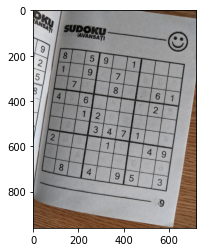

In [64]:
img = train_images[1]
gt = train_gt[1]

print(gt)
show_image_pyplot(img)

In [379]:
def remove_light_grays(img):
    img_hsv = cv.cvtColor(img, cv.COLOR_BGR2HSV)
    mask = cv.inRange(img_hsv, (0, 0, 100), (255, 20, 255))
    res = img.copy()
    res[np.where(mask)] = (255, 255, 255)
    return res

In [390]:
def preprocess_binary_image(image, kernel_size=(7, 7)):
    gray = cv.cvtColor(image, cv.COLOR_BGR2GRAY)
    applied_blur = cv.GaussianBlur(gray, kernel_size, 0)
    thresholded = cv.adaptiveThreshold(applied_blur, 255, cv.ADAPTIVE_THRESH_GAUSSIAN_C, cv.THRESH_BINARY, kernel_size[0], 2)
    inverted = cv.bitwise_not(thresholded)
    median_blur = cv.medianBlur(inverted, 5)
    return median_blur

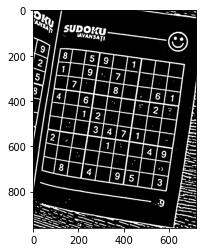

In [77]:
preprocessed_img = preprocess_binary_image(img)
show_image_pyplot(preprocessed_img)

In [81]:
def dilate_image(binary_img, kernel_size=3, iterations=1):
    kernel = np.ones((kernel_size, kernel_size), dtype=np.uint8)
    return cv.dilate(binary_img, kernel, iterations=iterations)

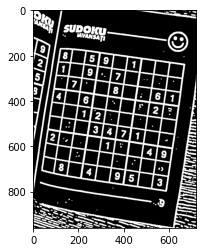

In [82]:
dilated_img = dilate_image(preprocessed_img)
show_image_pyplot(dilated_img)

In [383]:
def find_largest_polygon(binary_img):
    polygons, _ = cv.findContours(binary_img, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
    polygon = max(polygons, key=lambda p: cv.contourArea(p))
    approx_poly = polygon # cv.approxPolyDP(polygon, 0.05 * cv.arcLength(polygon, True), True)
    return approx_poly

In [116]:
sudoku_square = find_largest_polygon(dilated_img)

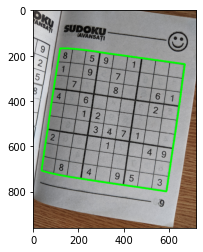

In [117]:
found_contour_img = cv.drawContours(img, [sudoku_square], 0, (0,255,0), 3)
show_image_pyplot(found_contour_img)

In [120]:
def get_corners(polygon):
    def get_max_vertex(cmp):
        return max([(vertex[0][0], vertex[0][1]) for vertex in polygon], key=cmp)
    tr = get_max_vertex(lambda p: p[0] - p[1])
    tl = get_max_vertex(lambda p: -p[0] - p[1])
    bl = get_max_vertex(lambda p: -p[0] + p[1])
    br = get_max_vertex(lambda p: p[0] + p[1])

    return (tr, tl, bl, br)

In [122]:
tr, tl, bl, br = get_corners(sudoku_square)

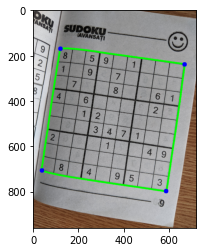

In [130]:
for corner in [tr, tl, bl, br]:
    found_contour_img = cv.circle(found_contour_img, (corner[0], corner[1]), 10, (255, 0, 0), thickness=-1)
show_image_pyplot(found_contour_img)

In [132]:
def compute_longest_side(tr, tl, bl, br):
    return max(
        distance.euclidean(tr, tl),
        distance.euclidean(bl, tl),
        distance.euclidean(br, bl),
        distance.euclidean(br, tr),
    )

In [133]:
side_len = compute_longest_side(tr, tl, bl, br)
side_len

563.848383876375

In [316]:
def warp_image(img, corners):
    tr, tl, bl, br = corners
    edge_len = int(compute_longest_side(tr, tl, bl, br))

    transform_matrix = cv.getPerspectiveTransform(
        np.array([tl, tr, br, bl], dtype=np.float32),
        np.array([[0, 0], [edge_len - 1, 0], [edge_len - 1, edge_len - 1], [0, edge_len - 1]], dtype=np.float32)
    )

    return cv.warpPerspective(img, transform_matrix, (edge_len, edge_len))

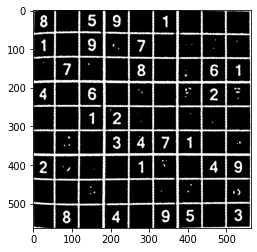

In [139]:
warped_binary = warp_binary_image(preprocessed_img, corners=(tr, tl, bl, br))
show_image_pyplot(warped_binary)

In [331]:
class CompletedBoxClassifier:
    def __init__(self, thresh):
        self.thresh = thresh

    def __call__(self, box):
        box_copy = box.copy()
        height, width = box_copy.shape

        max_area = 0
        digit_x, digit_y = None, None
        for x in range(width):
            for y in range(height):
                if box_copy[y, x] == 255:
                    area = cv.floodFill(box_copy, None, (x, y), 100)[0]
                    if area > max_area:
                        max_area = area
                        digit_x, digit_y = x, y

        if max_area == 0:
            return False

        cv.floodFill(box_copy, None, (digit_x, digit_y), 255)
        min_x, max_x = width, 0
        min_y, max_y = height, 0
        for x in range(width):
            for y in range(height):
                if box_copy[y, x] == 255:
                    min_x = min(min_x, x)
                    max_x = max(max_x, x)
                    min_y = min(min_y, y)
                    max_y = max(max_y, y)

        # s = set([])
        # for x in range(width):
        #     for y in range(height):
        #         s.add(box[y, x])
        # print(s) 
        
        # print((max_x - min_x) , (max_y - min_y) ,  width , height)

        return (max_x - min_x) * (max_y - min_y) > self.thresh * width * height

In [254]:
def classify_boxes(img, classifier, debug=False, margin_pct=0.20):
    box_len = int(img.shape[0] / 9)

    return_string = ""

    fig = plt.figure(figsize=(9, 9))
    fig.tight_layout()
    for i in range(9):
        for j in range(9):
            box = img[i * box_len:(i + 1) * box_len - 1, j * box_len:(j + 1) * box_len - 1].copy()
            margin = int(box_len * margin_pct)
            box = box[margin:-margin, margin:-margin]

            predicted = classifier(box)

            ax = fig.add_subplot(9, 9, i * 9 + j + 1)
            if predicted:
                plt.imshow(box)
                return_string += "x"
            else:
                plt.imshow(box, cmap="gray")
                return_string += "o"
            plt.axis("off")
        return_string += "\n"
    
    if debug:
        plt.show()
    else:
        fig.clear()
        plt.close(fig)

    return return_string[:-1]

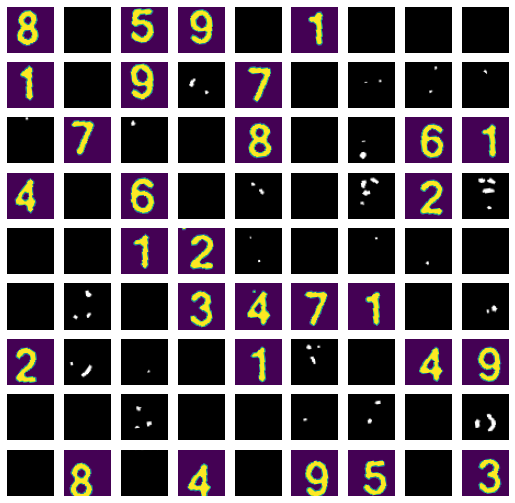

xoxxoxooo
xoxoxoooo
oxooxooxx
xoxooooxo
ooxxooooo
oooxxxxoo
xoooxooxx
ooooooooo
oxoxoxxox


In [191]:
predict_str = classify_boxes(warped_binary, CompletedBoxClassifier(), debug=True)
print(predict_str)
assert(predict_str == gt)

In [320]:
def make_prediction_task1(img, classifier, debug=False):
    if debug:
        show_image_pyplot(img)

    grays_removed = remove_light_grays(img)
    if debug:
        show_image_pyplot(grays_removed)
    plt.clf()
    
    preprocessed_img = preprocess_binary_image(grays_removed)
    if debug:
        show_image_pyplot(preprocessed_img)
    plt.clf()

    dilated_img = dilate_image(preprocessed_img)
    if debug:
        show_image_pyplot(dilated_img)
    plt.clf()

    sudoku_square = find_largest_polygon(dilated_img)
    found_contour_img = cv.drawContours(img, [sudoku_square], 0, (0,255,0), 3)
    tr, tl, bl, br = get_corners(sudoku_square)
    for corner in [tr, tl, bl, br]:
        found_contour_img = cv.circle(found_contour_img, (corner[0], corner[1]), 10, (255, 0, 0), thickness=-1)
    if debug:
        show_image_pyplot(found_contour_img)
    plt.clf()

    warped = warp_image(grays_removed, corners=(tr, tl, bl, br))
    warped_binary = preprocess_binary_image(warped)
    if debug:
        show_image_pyplot(warped_binary)
    plt.clf()

    predict_str = classify_boxes(warped_binary, classifier, debug=debug)
    plt.clf()

    return predict_str

In [332]:
classifier = CompletedBoxClassifier(thresh=0.1)

In [392]:
acc = 0
missed = []
for i, (img, gt) in enumerate(tqdm(zip(all_images, all_gt), total=len(all_images))):
    predicted = make_prediction_task1(img.copy(), classifier)
    if predicted == gt:
        acc += 1
    else:
        missed.append(i)
print(f"\n\n{acc * 100 / len(all_images):.3f}%")
print(missed)

100%|██████████| 50/50 [03:41<00:00,  4.42s/it]

94.000%
[6, 8, 25]



<Figure size 432x288 with 0 Axes>

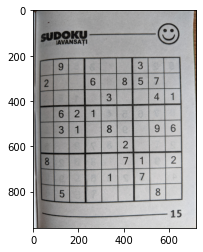

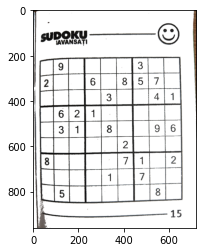

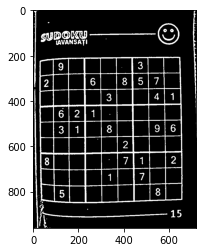

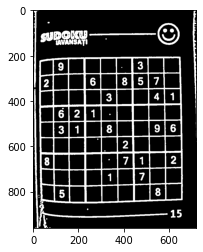

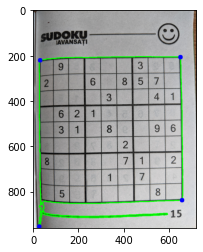

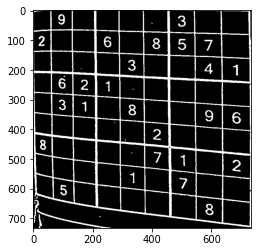

<Figure size 432x288 with 0 Axes>

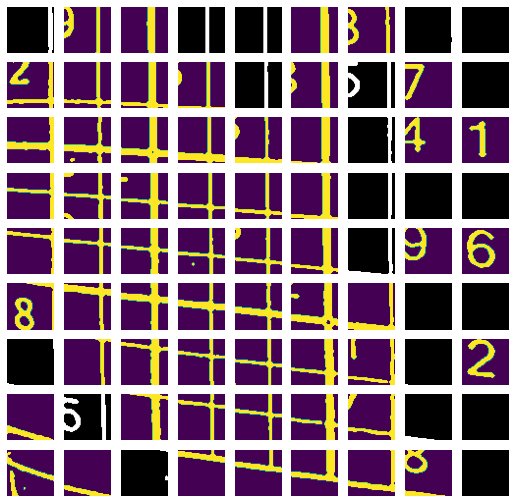

oxxooxxoo
xxxxoxoxo
xxxxxxoxx
xxxxxxooo
xxxxxxoxx
xxxxxxxoo
oxxxxxxox
xoxxxxxoo
xxoxxxxxo


<Figure size 432x288 with 0 Axes>

In [391]:
img = all_images[6].copy()
# img = img[:-int(img.shape[0] * 0.1), :, :]
gt = all_gt[8]
print(make_prediction_task1(img, classifier, debug=True))